In [1]:
import numpy as np
import pandas as pd
import time
import sys
import os
import h5py
from joblib import Parallel, delayed
sys.path.append('../')
from packages import actv_analysis, svm, load_csv, stats, objects, test_codes
import pickle
import re
import glob
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.preprocessing import MinMaxScaler

In [56]:
# Get the current directory
current_dir = os.getcwd()

# Go two directories up
up_two_dir = os.path.dirname(current_dir)

print(up_two_dir)

/Users/dongillee/Interference/codes


## Compute Kendall taus and save them as object attributes

In [ ]:
from scipy.stats import kendalltau
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
from joblib import Parallel, delayed

# Values for x-axis (numbers from 4 to 20 with an increment of 2)
numbers = list(range(4, 21, 2))
scaler = MinMaxScaler()
relu=4

def process_net_epoch(net, epoch):
    print(f"Processing for net: {net}, epoch: {epoch}")
    temp_results = []
    
    actv_net = actv_analysis.get_actv_net(net=net, relu=4, epoch=epoch)
    avg_actv_net_nxs = np.mean(actv_net, axis=2).reshape(actv_net.shape[0], 10, 10)[:, 1:, 3:]
    pkl_filename = f'{up_two_dir}/fig1/pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

    with open(pkl_filename, 'rb') as f:
        units = pickle.load(f)

    for unit_index, unit in enumerate(units):
        matrix = avg_actv_net_nxs[unit_index]
        matrix_normalized = scaler.fit_transform(matrix.reshape(-1, 1)).reshape(matrix.shape)
        df = pd.DataFrame(matrix_normalized, columns=['size_' + str(i) for i in range(1, 8)])
        df['numbers'] = numbers
        stats_dict = {}
        temp_list = []

        for size in df.columns[:-1]:  # exclude the 'numbers' column
            tau, p_value = kendalltau(numbers, df[size])
            temp_list.append({
                'net': net,
                'epoch': epoch,
                'unit': unit_index,
                'size': size,
                'tau': tau,
                'p_value': p_value
            })
            stats_dict[size] = {'tau': tau, 'p_value': p_value}

        # For averaged activity across sizes
        averaged_activity_sizes = df.drop(columns=['numbers']).mean(axis=1)
        tau_avg_sizes, p_value_avg_sizes = kendalltau(numbers, averaged_activity_sizes)
        temp_list.append({
            'net': net,
            'epoch': epoch,
            'unit': unit_index,
            'size': 'averaged_across_sizes',
            'tau': tau_avg_sizes,
            'p_value': p_value_avg_sizes
        })
        stats_dict['averaged_across_sizes'] = {'tau': tau_avg_sizes, 'p_value': p_value_avg_sizes}

        # For averaged activity across numbers
        averaged_activity_numbers = df.drop(columns=['numbers']).mean(axis=0)
        tau_avg_numbers, p_value_avg_numbers = kendalltau(range(1, 8), averaged_activity_numbers)
        temp_list.append({
            'net': net,
            'epoch': epoch,
            'unit': unit_index,
            'size': 'averaged_across_numbers',
            'tau': tau_avg_numbers,
            'p_value': p_value_avg_numbers
        })
        stats_dict['averaged_across_numbers'] = {'tau': tau_avg_numbers, 'p_value': p_value_avg_numbers}

        for idx, row in df.iterrows():
            current_number = row['numbers']
            tau_size, p_value_size = kendalltau(range(1, 8), row.drop('numbers').values)
            temp_list.append({
                'net': net,
                'epoch': epoch,
                'unit': unit_index,
                'number': current_number,
                'tau': tau_size,
                'p_value': p_value_size
            })
            stats_dict[f'number_{current_number}'] = {'tau': tau_size, 'p_value': p_value_size}

        setattr(unit, 'kendall_stats', stats_dict)
        temp_results.extend(temp_list)

    with open(pkl_filename, 'wb') as f:
        pickle.dump(units, f)

    return temp_results

# Run parallel computation
all_results = Parallel(n_jobs=-1)(delayed(process_net_epoch)(net, epoch) for net in range(1, 11) for epoch in [0, 90])

# Collate results and inspect
results_df = pd.DataFrame([item for sublist in all_results for item in sublist])
print(results_df)

## Plot units of interest

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle

def plot_unit(net, relu, epoch, unit_id, actv_net, plot_average=False):
    # Values for x-axis (numbers from 4 to 20 with an increment of 2)
    numbers = list(range(4, 21, 2))
    scaler = MinMaxScaler()
    
    avg_actv_net_nxs = np.mean(actv_net, axis=2).reshape(actv_net.shape[0], 10, 10)[:, 1:, 3:]
    
    pkl_filename = f'../../pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

    # Load units from the pickle file
    with open(pkl_filename, 'rb') as f:
        units = pickle.load(f)

    # Extract the specific unit and matrix using unit_id
    unit = units[unit_id]
    matrix = avg_actv_net_nxs[unit_id]

    # Apply Min-Max normalization to the matrix
    matrix_normalized = scaler.fit_transform(matrix.reshape(-1, 1)).reshape(matrix.shape)

    # Convert the normalized matrix to a dataframe
    df = pd.DataFrame(matrix_normalized, columns=['size_' + str(i) for i in range(1, 8)])
    df['numbers'] = numbers

    # Melt the dataframe to a long format
    df_melted = df.melt(id_vars=['numbers'], value_vars=['size_' + str(i) for i in range(1, 8)], var_name='size', value_name='value')

    # Plotting
    plt.figure(figsize=(8, 8))

    # Using 'rocket' colormap
    colors = sns.color_palette("rocket", n_colors=7)
    sns.lineplot(data=df_melted, x='numbers', y='value', hue='size', palette=colors, linewidth=2.5)

    if plot_average:
        # Calculate the average curve and plot it
        df['average'] = df[['size_' + str(i) for i in range(1, 8)]].mean(axis=1)
        plt.plot(numbers, df['average'], color='blue', linewidth=2.5, label='Average')
    
    # Annotations for coeff1 and coeff2
    basic_annotations = [f'{attr}: {getattr(unit, attr):.6f}' for attr in ['coeff1', 'coeff2'] if hasattr(unit, attr)]

    # Extracting and formatting kendall_stats for annotation
    kendall_annotations = []
    if hasattr(unit, 'kendall_stats'):
        for size, stats in unit.kendall_stats.items():
            kendall_tau = stats.get('tau', 'N/A')
            kendall_p_value = stats.get('p_value', 'N/A')
            kendall_annotations.append(f'{size} - Tau: {kendall_tau:.6f}, P-Value: {kendall_p_value:.6f}')

    # Adding r_sqrd to the annotations
    r_sqrd_annotation = []
    if hasattr(unit, 'r_sqrd'):
        r_sqrd_annotation = [f'R-Squared: {unit.r_sqrd:.6f}']

    # Extracting and formatting anova2_numbers and anova2_sizes for annotation
    anova2_annotations = []
    if hasattr(unit, 'anova2_numbers') and unit.anova2_numbers is not None:
        anova2_annotations.append(f'ANOVA2 Numbers: {unit.anova2_numbers:.6f}')
    if hasattr(unit, 'anova2_sizes') and unit.anova2_sizes is not None:
        anova2_annotations.append(f'ANOVA2 Sizes: {unit.anova2_sizes:.6f}')

    # Combining all the annotations
    all_annotations = '\n'.join(basic_annotations + kendall_annotations + r_sqrd_annotation + anova2_annotations)

    # Adding the combined annotations to the plot, adjusting position
    plt.annotate(all_annotations, xy=(0.05, 0.85), xycoords='axes fraction', fontsize=8, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    identifier = unit.id
    plt.title(f'Net: {net} | Relu: {relu} | Epoch: {epoch} | Unit: {identifier}')
    
    plt.xlabel('Numbers')
    plt.ylabel('Normalized Value')

    if plot_average:
        plt.legend(title='Sizes', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.legend().remove()  # Remove legend for clarity

    # Save the figure
    plt.savefig(f'net_{net}_relu_{relu}_epoch_{epoch}_normalized_line_plot_unit_{identifier}.pdf')
    plt.close()  # Close the figure to free up memory
    

def analyze_and_plot_units(net, relu, epoch, unit_type):
    # Load actv_net using the provided actv_analysis function
    actv_net = actv_analysis.get_actv_net(net=net, relu=relu, epoch=epoch)
    
    pkl_filename = f'{up_two_dir}/fig1/pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'
    
    # Load units from the pickle file
    with open(pkl_filename, 'rb') as f:
        units = pickle.load(f)

    units_coeff1 = [unit.coeff1 for unit in units]
    units_coeff2 = [unit.coeff2 for unit in units]
    units_rsqrd = [unit.r_sqrd for unit in units]
    units_anova2_num = [unit.anova2_numbers for unit in units]
    units_anova2_sz = [unit.anova2_sizes for unit in units]
    
    units_coeff = pd.DataFrame({
        'coeff1': units_coeff1, 
        'coeff2': units_coeff2, 
        'rsqrd': units_rsqrd, 
        'anova2_num': units_anova2_num, 
        'anova2_sz': units_anova2_sz
    })
    
    if unit_type == 'number':
        selected_units = np.arange(len(units))[(units_coeff['rsqrd'] > 0.1) & (units_coeff['anova2_num'] < 0.01) & (units_coeff['anova2_sz'] > 0.01)]
    elif unit_type == 'Q1':
        selected_units = np.arange(len(units))[(units_coeff['coeff1'] > 0) & (units_coeff['coeff2'] > 0) & (units_coeff['rsqrd'] > 0.1) & (units_coeff['anova2_num'] < 0.01) & (units_coeff['anova2_sz'] < 0.01)]
    elif unit_type == 'Q2':
        selected_units = np.arange(len(units))[(units_coeff['coeff1'] < 0) & (units_coeff['coeff2'] > 0) & (units_coeff['rsqrd'] > 0.1) & (units_coeff['anova2_num'] < 0.01) & (units_coeff['anova2_sz'] < 0.01)]
    elif unit_type == 'Q3':
        selected_units = np.arange(len(units))[(units_coeff['coeff1'] < 0) & (units_coeff['coeff2'] < 0) & (units_coeff['rsqrd'] > 0.1) & (units_coeff['anova2_num'] < 0.01) & (units_coeff['anova2_sz'] < 0.01)]
    elif unit_type == 'Q4':
        selected_units = np.arange(len(units))[(units_coeff['coeff1'] > 0) & (units_coeff['coeff2'] < 0) & (units_coeff['rsqrd'] > 0.1) & (units_coeff['anova2_num'] < 0.01) & (units_coeff['anova2_sz'] < 0.01)]
    else:
        raise ValueError("Invalid unit_type. Accepted values are 'number', 'Q1', 'Q2', 'Q3', 'Q4'.")

    #Parallel(n_jobs=-1)(delayed(plot_unit)(net=net, relu=relu, epoch=epoch, unit_id=unit_id, actv_net=actv_net) for unit_id in selected_units)
    
    return selected_units

In [18]:
net=1; relu=4; epoch=90
actv_net = actv_analysis.get_actv_net(net=net, relu=relu, epoch=epoch)

--- 97.16331624984741 seconds ---


In [19]:
# net=1; relu=4; epoch=0
# pkl_filename = f'../../pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

# with open(pkl_filename, 'rb') as f:
#     units0 = pickle.load(f)
    
net=1; relu=4; epoch=90
pkl_filename = f'../../pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

with open(pkl_filename, 'rb') as f:
    units90 = pickle.load(f)

In [22]:
fit = pd.DataFrame([[units90[i].coeff1, units90[i].coeff2, units90[i].r_sqrd] for i in range(len(units90))])
Q2 = fit[(fit.iloc[:,0]<0)&(fit.iloc[:,1]>0)&(fit.iloc[:,2]>0.9)].index

In [23]:
net=1; relu=4; epoch=90
Parallel(n_jobs=-1)(delayed(plot_unit)(net, relu, epoch, unit_id, actv_net, plot_average=True) for unit_id in Q2)

KeyboardInterrupt: 

In [34]:
import pickle
import pandas as pd

# Empty lists to store extracted values
unitid_list = []
tau_nb_list = []
tau_sz_list = []
net_list = []
epoch_list = []

# Given up_two_dir definition (assuming it's defined in your environment)
# up_two_dir = ...

# Loop over the desired range of values
for net in range(1, 11):  # net from 1 to 10
    for relu in [4]:
        for epoch in [0, 90]:  # epoch can be 0 or 90
            pkl_filename = f'{up_two_dir}/fig1/pkl/4to20/network{net}_Relu{relu}_epoch{epoch}_4to20.pkl'

            # Load units from the pickle file
            with open(pkl_filename, 'rb') as f:
                units0 = pickle.load(f)

            # Extract relevant information and append to lists
            unitid_list.extend([unit.id for unit in units0 if unit.r_sqrd > 0.1])
            tau_nb_list.extend([unit.kendall_stats['averaged_across_sizes']['tau'] for unit in units0 if unit.r_sqrd > 0.1])
            tau_sz_list.extend([unit.kendall_stats['averaged_across_numbers']['tau'] for unit in units0 if unit.r_sqrd > 0.1])
            net_list.extend([net] * len([unit for unit in units0 if unit.r_sqrd > 0.1]))  # Repeat net value for the number of units satisfying the condition
            epoch_list.extend([epoch] * len([unit for unit in units0 if unit.r_sqrd > 0.1]))

# Construct a DataFrame
df = pd.DataFrame({
    'id': unitid_list,
    'tau_nb': tau_nb_list,
    'tau_sz': tau_sz_list,
    'net': net_list,
    'epoch': epoch_list
})

print(df)

            id    tau_nb    tau_sz  net  epoch
0            0 -0.555556 -0.904762    1      0
1            1 -0.055556  1.000000    1      0
2            2 -0.111111  0.809524    1      0
3            3 -0.555556  0.904762    1      0
4            4  0.000000  0.809524    1      0
...        ...       ...       ...  ...    ...
1158996  64891  0.944444  0.809524   10     90
1158997  64892  1.000000  0.809524   10     90
1158998  64893  1.000000  0.714286   10     90
1158999  64894  1.000000  0.619048   10     90
1159000  64895  1.000000  0.428571   10     90

[1159001 rows x 5 columns]


/var/folders/yq/vnn1qzt56k7041vctbsfrxj40000gn/T/ipykernel_6382/792563037.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  proportions_net = [len(df_net[condition])/len(df_net) for condition in conditions]


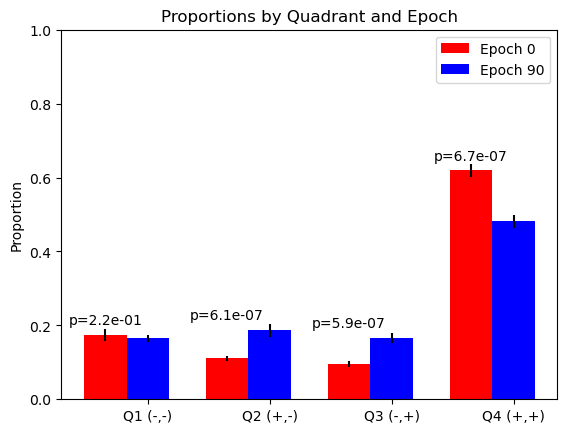

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

def plot_bar_quadrants_with_error(df):
    # Define the quadrants
    conditions = [
        (df['tau_nb'] < 0) & (df['tau_sz'] < 0),
        (df['tau_nb'] >= 0) & (df['tau_sz'] < 0),
        (df['tau_nb'] < 0) & (df['tau_sz'] >= 0),
        (df['tau_nb'] >= 0) & (df['tau_sz'] >= 0)
    ]
    quadrant_names = ['Q1 (-,-)', 'Q2 (+,-)', 'Q3 (-,+)', 'Q4 (+,+)']
    
    epochs = df['epoch'].unique()
    
    proportions_by_epoch = {}
    
    for epoch in epochs:
        proportions_all_nets = []
        for net in df['net'].unique():
            df_net = df[(df['epoch'] == epoch) & (df['net'] == net)]
            
            proportions_net = [len(df_net[condition])/len(df_net) for condition in conditions]
            proportions_all_nets.append(proportions_net)
            
        proportions_by_epoch[epoch] = proportions_all_nets

    # Compute average and std dev
    avg_proportions = {epoch: np.mean(proportions, axis=0) for epoch, proportions in proportions_by_epoch.items()}
    std_devs = {epoch: np.std(proportions, axis=0) for epoch, proportions in proportions_by_epoch.items()}

    # Setting bar width and position
    barWidth = 0.35
    r1 = np.arange(len(avg_proportions[0]))
    r2 = [x + barWidth for x in r1]

    bars1 = plt.bar(r1, avg_proportions[0], width=barWidth, color='red', label='Epoch 0', yerr=std_devs[0])
    bars2 = plt.bar(r2, avg_proportions[90], width=barWidth, color='blue', label='Epoch 90', yerr=std_devs[90])
        
    p_values = []

    for i in range(4):  # As there are four quadrants
        data_epoch_0 = [prop[i] for prop in proportions_by_epoch[0]]
        data_epoch_90 = [prop[i] for prop in proportions_by_epoch[90]]

        if len(data_epoch_0) == len(data_epoch_90):
            _, p_val = ttest_rel(data_epoch_0, data_epoch_90)
            p_values.append(p_val)
        else:
            p_values.append(np.nan)

    for i, rect0, rect1 in zip(range(4), bars1, bars2):
        height = max(rect0.get_height(), rect1.get_height())
        plt.text(rect0.get_x() + rect0.get_width()/2, height + 0.02, f'p={p_values[i]:.1e}', ha='center', va='bottom')

    plt.ylabel('Proportion')
    plt.title('Proportions by Quadrant and Epoch')
    plt.xticks([r + barWidth for r in range(len(avg_proportions[0]))], quadrant_names)
    plt.legend()
    plt.ylim(0, 1)  # Ensure y-axis limits are between 0 and 1
    plt.savefig('unit_types_by_Ktau.pdf')
    plt.show()

# Call the modified function
plot_bar_quadrants_with_error(df)

/var/folders/yq/vnn1qzt56k7041vctbsfrxj40000gn/T/ipykernel_6382/2960058326.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  proportions_Q1Q4 = len(df_net[conditions[0]]) / len(df_net)
/var/folders/yq/vnn1qzt56k7041vctbsfrxj40000gn/T/ipykernel_6382/2960058326.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  proportions_Q2Q3 = len(df_net[conditions[1]]) / len(df_net)


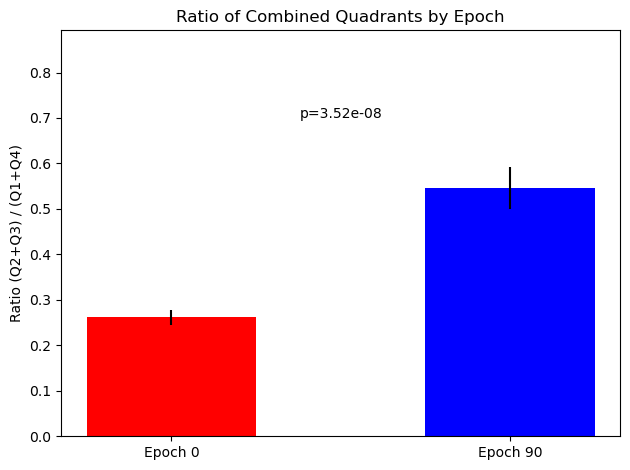

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

def plot_ratio_bar_quadrants_with_error(df):
    # Define the combined groups
    conditions = [
        ((df['tau_nb'] < 0) & (df['tau_sz'] < 0)) | ((df['tau_nb'] >= 0) & (df['tau_sz'] >= 0)),  # Q1 + Q4
        ((df['tau_nb'] >= 0) & (df['tau_sz'] < 0)) | ((df['tau_nb'] < 0) & (df['tau_sz'] >= 0))   # Q2 + Q3
    ]
    
    epochs = [0, 90]  # Given that you specified epochs 0 and 90
    
    ratios_by_epoch = {}
    
    for epoch in epochs:
        ratios_all_nets = []
        for net in df['net'].unique():
            df_net = df[(df['epoch'] == epoch) & (df['net'] == net)]
            
            proportions_Q1Q4 = len(df_net[conditions[0]]) / len(df_net)
            proportions_Q2Q3 = len(df_net[conditions[1]]) / len(df_net)
            
            ratio = proportions_Q2Q3 / proportions_Q1Q4 if proportions_Q1Q4 != 0 else np.nan
            ratios_all_nets.append(ratio)
            
        ratios_by_epoch[epoch] = ratios_all_nets

    # Compute average and std dev for the ratios
    avg_ratios = {epoch: np.mean(ratios) for epoch, ratios in ratios_by_epoch.items()}
    std_devs = {epoch: np.std(ratios) for epoch, ratios in ratios_by_epoch.items()}

    # Paired t-test
    _, p_value = ttest_rel(ratios_by_epoch[0], ratios_by_epoch[90])

    # Define bar positions and width
    bar_positions = [0, 1]
    bar_width = 0.5

    # Plot the ratios
    bars = plt.bar(bar_positions, avg_ratios.values(), width=bar_width, yerr=std_devs.values(), color=['red', 'blue'], tick_label=['Epoch 0', 'Epoch 90'])
    
    # Annotate with p-value
    y_max = max(avg_ratios.values()) + max(std_devs.values()) + 0.1
    plt.annotate(f'p={p_value:.2e}', 
                 xy=(0.5, y_max), xycoords='data',
                 ha='center', va='bottom', fontsize=10)

    plt.ylabel('Ratio (Q2+Q3) / (Q1+Q4)')
    plt.title('Ratio of Combined Quadrants by Epoch')
    plt.ylim(0, y_max + 0.2)  # Adjust the ylim based on your data and annotation
    plt.tight_layout()
    plt.savefig('ratio_by_Ktau.pdf')
    plt.show()

# Call the modified function
plot_ratio_bar_quadrants_with_error(df)

In [114]:
coeffs_epoch0 = pd.DataFrame([[units0[i].coeff1, units0[i].coeff2] for i in range(len(units0))],columns=['coeff1','coeff2'])
coeffs_epoch90 = pd.DataFrame([[units90[i].coeff1, units90[i].coeff2] for i in range(len(units90))],columns=['coeff1','coeff2'])

ktaus0 = pd.DataFrame([[units0[i].kendall_stats['averaged_across_sizes']['tau'], 
                   units0[i].kendall_stats['averaged_across_numbers']['tau']] for i in range(len(units0))])

ktaus90 = pd.DataFrame([[units90[i].kendall_stats['averaged_across_sizes']['tau'], 
                   units90[i].kendall_stats['averaged_across_numbers']['tau']] for i in range(len(units90))])

<Axes: xlabel='coeff1', ylabel='coeff2'>

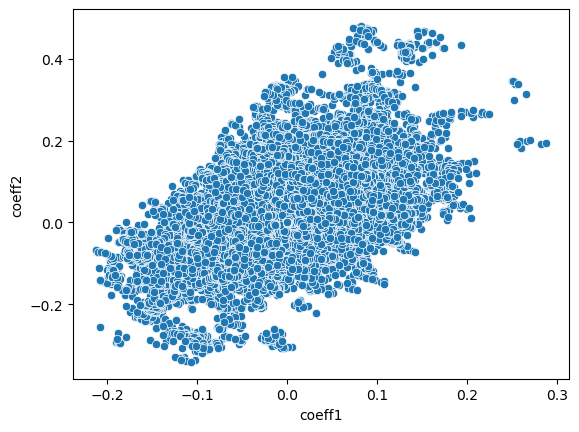

In [112]:
sns.scatterplot(coeffs_epoch0, x='coeff1', y='coeff2')

<Axes: xlabel='coeff1', ylabel='coeff2'>

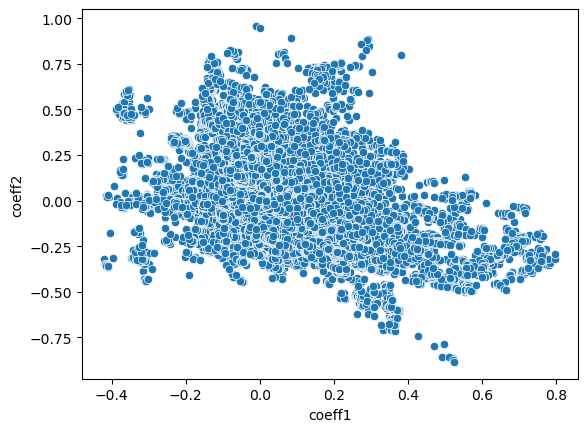

In [113]:
sns.scatterplot(coeffs_epoch90, x='coeff1', y='coeff2')

In [126]:
dat = pd.concat([coeffs_epoch90, ktaus90],axis=1).dropna()
dat.columns = dat.columns.astype(str)

In [127]:
pca = PCA(n_components=2)  # Adjust n_components as needed
dat_pca = pca.fit_transform(dat.to_numpy())

In [128]:
n_clusters = 3  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(dat_pca)

/Users/dongillee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


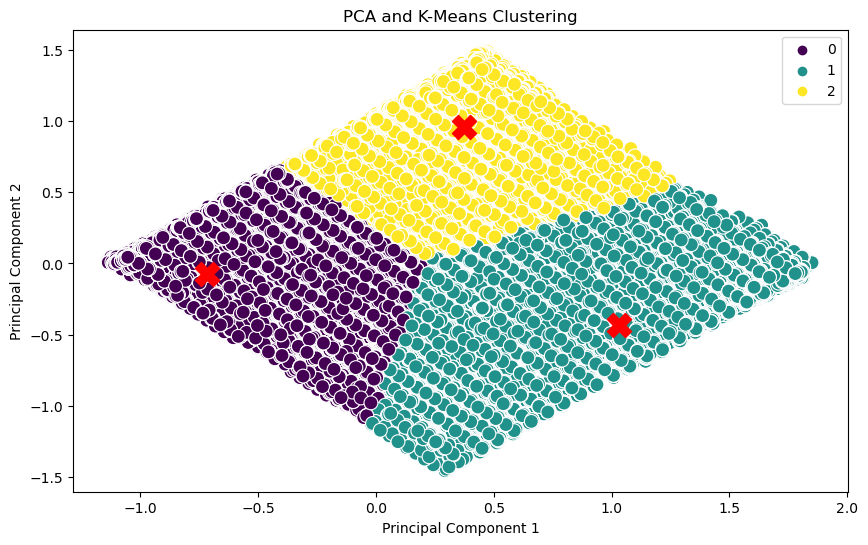

In [129]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dat_pca[:, 0], y=dat_pca[:, 1], hue=clusters, palette="viridis", s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X')
plt.title('PCA and K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()